# Описание проекта

Программа для поиска оптимальных маршрутов через API Яндекс.Расписаний
Пользователь вводит:
- пункт отправления
- пункт назначения
- дату поездки

Программа возвращает:
- самый быстрый вариант маршрута
- самый дешевый вариант маршрута

# Программа

In [10]:
# импортируем библиотеки
import requests
import pandas as pd
import numpy as np

функция для работы с серией про цены ( она понадобится потом), но суть в том что мы получаем цену самого дешевого билета на рейсе( если о них вообще есть информация в рублях)


In [11]:
def lowest_price(array):
    try:
        if array:
            cheapest_dict = min(array, key= lambda x: int(x['price']['whole'])) # получаем самый дешевый словарь
            if cheapest_dict['currency'] == 'RUB':
                price = cheapest_dict['price']['whole']

            else:
                price = None
            return price
        else:
            return None
    except:
        return None

Функция, которая преобразует название региона (области) и населенного пункта в код этого населенного пунка

In [12]:
def city_to_code(region, city):
    try:
        if region == 'московская область':
            region ='москва и московская область'
        elif region =='ленинградская область':
            region = 'санкт-петербург и ленинградская область'
        df = pd.read_csv('https://raw.githubusercontent.com/Alexander-768/just_for_API_flights/refs/heads/main/all_staitions_without_nan_as_cs.csv', index_col=0)
        city_code = df.query('Region == @region and City == @city')
        return city_code['City_code'].to_list()[0]
    except:
        return None

Функция для получения самых дешевых поездок из итогового датафрейма

In [13]:
def the_cheapest(df: pd.DataFrame):

        min_val = df['lowest_ticket'].min(skipna=True)
        if min_val is not np.nan:
            return df.query('lowest_ticket == @min_val')
        else:
            return 'Информации о стоимости билетов на рейсы отсутствует'

 Функция для получения самых быстрых поездок из итогового датафрейма

In [14]:
def the_fastest(df: pd.DataFrame):

    min_val = min(df['duration_hours'])
    return df.query('duration_hours == @min_val')


Основная функция, которая на основе кода населенного пункта отпраления, кода населенного пункта прибытия и дате возвращает датафрейм  с всеми рейсами соответствующими заданным аргументам

Смысл столбцов:

*   thread.number - номер рейса
*  thread.title-  названием нитки ( названия первой - последней станции следования транспорта)
*   from.title -  название пункта отправления
*   to.title -  название станции прибытия
*   departure - время отправления
*   arrival - время прибытия
*   duration_hours- часы в пути
*   thread.transport_type - тип транспорта
*   lowest_ticket - Цена самого дешевого билет на рейсе ( при налиичии информациии)











Пример датафрейма с запросом кода Иваново, кода МСК, и датой 2025-03-27

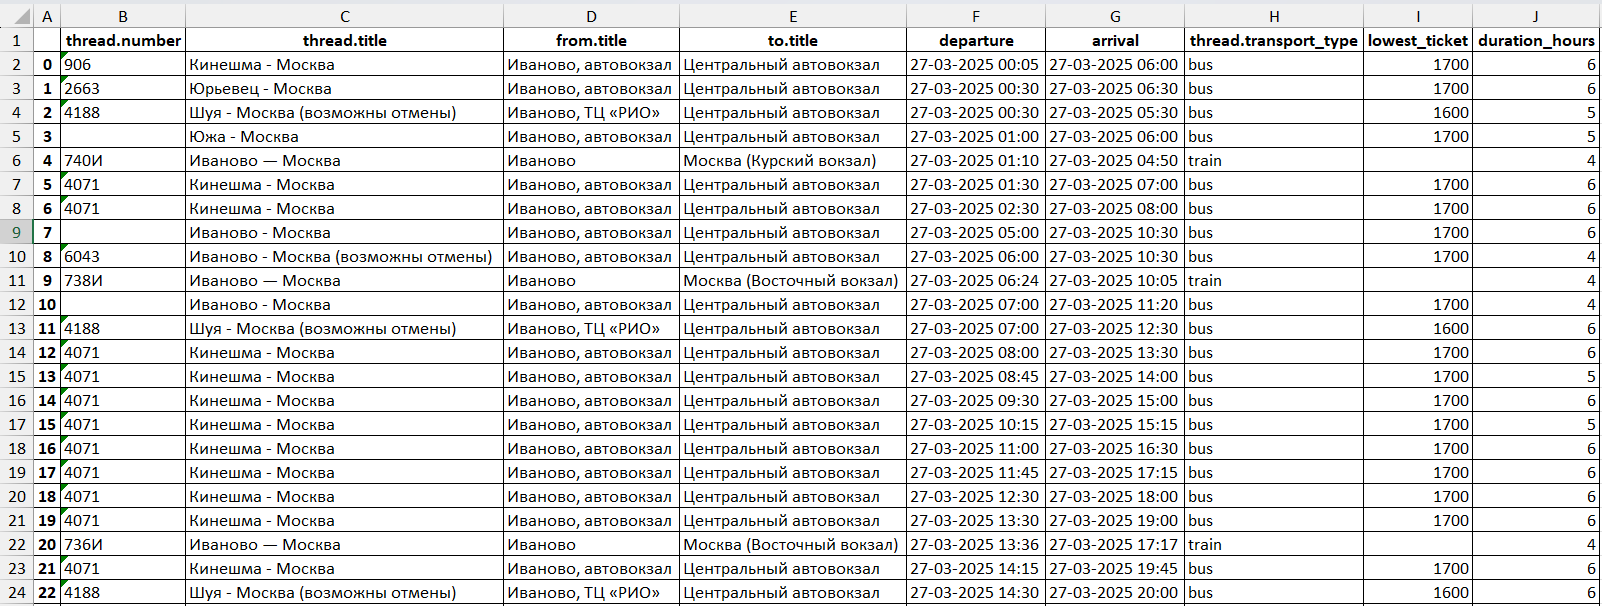

In [15]:
def get_relevant_flights(from_code, to_code, date):
    try:
        url = 'https://api.rasp.yandex.net/v3.0/search/'

        params = {'apikey':'b0bc7a97-f602-4cbc-a762-ad889e5f3c86',
                'from': f'{from_code}',
                'to': f'{to_code}',
                'date': f'{date}',
                'lang' :'ru_RU'}
        # Отправляем GET-запрос
        response = requests.get(url, params= params)

        # Проверяем успешность запроса
        if response.status_code == 200:
            # Получаем данные в формате JSON
            data = response.json()

        else:
            print(f"Ошибка: {response.status_code}")


        # Извлекаем сегменты поездок (Список найденных рейсов)
        segments = data['segments']


        # Создаем DataFrame
        df = pd.json_normalize(segments, sep='.')

        # Отбираем нужные столбцы
        columns_to_keep = ['thread.number', 'thread.title', 'from.title', 'to.title',
                        'departure', 'arrival', 'duration', 'thread.transport_type', 'tickets_info.places']
        df = df[columns_to_keep]

        # Приводим время к нужному формату
        df['departure'] = pd.to_datetime(df['departure']).dt.strftime('%d-%m-%Y %H:%M')
        df['arrival'] = pd.to_datetime(df['arrival']).dt.strftime('%d-%m-%Y %H:%M')

        # Переводим длительность в часы
        df['duration_hours'] = df['duration'].apply(lambda x: round(x / 3600))

        # Убираем ненужные столбцы
        df.drop(columns=['duration'], inplace=True)
        df['tickets_info.places'] = df['tickets_info.places'].apply(lowest_price)
        df = df.rename(columns={'tickets_info.places': 'lowest_ticket'})
        return df
    except:
        return 'Не удалось найти актуальных данных по вашему запросу, введите корректные данные'

# Взамиодействие

In [16]:
area_from = input('Введите область отправления: ').lower()
city_from = input('Введите населенный пункт отправления: ').lower()
area_to = input('Введите область прибытия: ').lower()
city_to = input('Введите населенный пункт прибытия: ').lower()
actual_date = input('Введите дату в формате YYYY-MM-DD: ')

from_code = city_to_code(area_from, city_from)
print(from_code)

to_code = city_to_code(area_to, city_to)
print(to_code)

df_with_all_flights = (get_relevant_flights(from_code=from_code, to_code=to_code, date=actual_date)) # датафрейм со всеми подходящими рейсами
print(df_with_all_flights)
if type(df_with_all_flights) != str:
    the_lowest_price_only = df_with_all_flights['lowest_ticket'].min(skipna=True)
    if the_lowest_price_only is not np.nan:
        print(f'Самая низкая цена: {the_lowest_price_only} руб')
    print(the_cheapest(df_with_all_flights))
    the_shortest_duration = df_with_all_flights['duration_hours'].min(skipna=True)
    if the_shortest_duration is not np.nan:
        print(f'Наименьшее время в пути: {the_shortest_duration} часа(-ов)')
    print(the_fastest(df_with_all_flights))


Введите область отправления: Московская область
Введите населенный пункт отправления: Москва
Введите область прибытия: Ивановская область
Введите населенный пункт прибытия: Иваново
Введите дату в формате YYYY-MM-DD: 2025-03-30
c213
c5
   thread.number                  thread.title                   from.title  \
0                 Москва — Иваново, автовокзал       Центральный автовокзал   
1                 Москва — Иваново, автовокзал       Центральный автовокзал   
2           732Я              Москва — Иваново      Москва (Курский вокзал)   
3                 Москва — Иваново, автовокзал       Центральный автовокзал   
4           733Я              Москва — Иваново    Москва (Восточный вокзал)   
5                 Москва — Иваново, автовокзал       Центральный автовокзал   
6                             Москва — Кинешма       Центральный автовокзал   
7                             Москва — Кинешма       Центральный автовокзал   
8                                 Москва — Шуя       Ц